# Лабораторная работа № 1. Обработка естественного языка.




###### Провели предсказания заработной платы с помощью нейронных сетей и попробовали разные модели для них. 
 Добавление параллельных сверточных слоев и дополнительное увеличение количества сверточных слоев не увеличило значительно предсказания. Аналогично, добавление Pooling слоев не поменяло кардинально ситуацию. Использование предобученных весов вместо замороженных улучшало работу модели, но так же незначительно. Лучший результат появился при добавлении рекуррентных слоев в пункте 4.


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
!unzip Train_rev1.zip
data = pd.read_csv("./drive/MyDrive/IAD seminars/11.02.2021/Train_rev1.csv", index_col=None)
data.shape

--2021-04-26 18:40:09--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.74.77
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.74.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip’

Train_rev1.zip      100%[===================>] 122.41M  31.1MB/s    in 4.6s    

2021-04-26 18:40:14 (26.7 MB/s) - ‘Train_rev1.zip’ saved [128356352/128356352]

Archive:  Train_rev1.zip
  inflating: Train_rev1.csv          


(244768, 12)

In [4]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [5]:
data.shape

(244768, 12)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


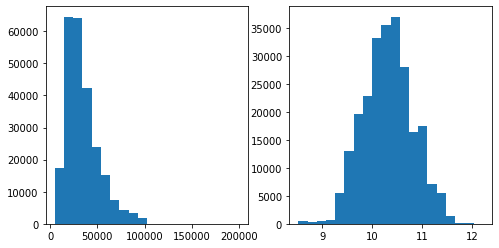

In [7]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

In [8]:
text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
122643,69940205,HFM Consultant / Senior Consultant PureApps,Oracle Hyperion HFM Consultant / Senior Consul...,London South East,South East London,NaN,permanent,Pureapps Ltd,IT Jobs,"From 50,000 to 80,000 per annum plus Excellent...",65000,cwjobs.co.uk,11.082158
49876,68628150,"Senior Support Engineer Windows, Citrix, VMware",SENIOR Support Engineer REQUIRED IN BRISTOL FO...,Somerset Bristol BS483,West Town,NaN,permanent,Randstad Technologies,IT Jobs,28000.00 - 37000.00 GBP Annual,32500,jobserve.com,10.389026
238409,72610432,Quantity Surveyor Transmission & Distribution,Quantity Surveyor Transmission Distribution A...,UK,UK,NaN,permanent,Cobalt Recruitment,Trade & Construction Jobs,45000 - 50000 per annum + benefits,47500,careerstructure.com,10.768506


In [9]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [10]:
data['Title'] = data['Title'].fillna('Nan')

In [11]:
import nltk
data['FullDescription'] = data['FullDescription'].str.lower()
data['Title'] = data['Title'].str.lower()

tokenizer = nltk.tokenize.WordPunctTokenizer()

data['FullDescription'] = data['FullDescription'].map(lambda x: ' '.join(tokenizer.tokenize(x)))
data['Title'] = data['Title'].map(lambda x: ' '.join(tokenizer.tokenize(x)))


In [12]:
from collections import Counter
token_counts = Counter()

for text in pd.concat([data['Title'], data["FullDescription"]]):
    token_counts.update(text.split())

In [13]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)


Выберем слова, которые встречались как минимум 10 раз.

In [14]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens
print("Vocabulary size:", len(tokens))

Vocabulary size: 34158


Построим словарь, где к каждому слову ключом будет являтся количество его появлений. 

In [15]:
token_to_id = {t: i for i, t in enumerate(tokens)}

Используем созданный словарь для отображения текстовых строк в удобные для нейронной сети матрицы.

In [16]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [17]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


In [18]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
               sparse=False)

In [19]:
data[categorical_columns].head().to_dict(orient='list')

{'Category': ['Engineering Jobs',
  'Engineering Jobs',
  'Engineering Jobs',
  'Engineering Jobs',
  'Engineering Jobs'],
 'Company': ['Gregory Martin International',
  'Gregory Martin International',
  'Gregory Martin International',
  'Gregory Martin International',
  'Gregory Martin International'],
 'ContractTime': ['permanent',
  'permanent',
  'permanent',
  'permanent',
  'permanent'],
 'ContractType': ['NaN', 'NaN', 'NaN', 'NaN', 'NaN'],
 'LocationNormalized': ['Dorking', 'Glasgow', 'Hampshire', 'Surrey', 'Surrey']}

# The deep learning part

In [20]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [21]:
import torch

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors

def make_batch(data, max_len=None, word_dropout=0, device=torch.device('cpu')):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)
    
    if TARGET_COLUMN in data.columns:
        batch['target_column'] = data[TARGET_COLUMN].values
    
    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [22]:
make_batch(data_train[:3], max_len=10)

{'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]]),
 'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]]),
 'target_column': tensor([ 9.7115, 10.4631, 10.7144])}

### Архитектура
Наша базовая модель состоит из трех ветвей: : Title encoder, Description encoder, Categorical features encoder. 

In [23]:
import torch
import torch.nn as nn
import torch.functional as F

In [24]:
temp = make_batch(data_train[:3], max_len=10)
temp['Title'].shape, temp['FullDescription'].shape

(torch.Size([3, 7]), torch.Size([3, 10]))

### Развейте СNN архитектуру (2 балла). Добавьте в пайплайн:
1. Batch Norm (nn.BatchNorm)

In [25]:
class SalaryPredictor_first(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_title = nn.Embedding(n_tokens, 32)
        self.batch_title = nn.BatchNorm1d(32)
        self.conv_title = nn.Conv1d(32, 16, 2)
        self.pool_title = nn.MaxPool1d(2)

        self.emb_des = nn.Embedding(n_tokens, 32)
        self.batch_des = nn.BatchNorm1d(32)
        self.conv_des = nn.Conv1d(32, 16, 2)
        self.pool_des = nn.MaxPool1d(2)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
        
    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        title = title.permute((0, 2, 1))
        title = self.conv_title(title)
        title = self.pool_title(title).mean(1)

        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des(des)
        des = self.pool_des(des).mean(1)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, des, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()
        
        
Salary_Pred_first = SalaryPredictor_first()   

In [26]:
model_first = SalaryPredictor_first()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_first(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

Training and evaluation

In [25]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=torch.device('cpu'), **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            yield batch
        
        if not cycle: break


Model training

In [26]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

In [27]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch['target_column']))
            abs_error += torch.sum(torch.abs(batch_pred - batch['target_column']))
            num_samples += len(batch)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


 results:
Mean square error: 426.76356
Mean absolute error: 41.26380
 results:
Mean square error: 426.70445
Mean absolute error: 41.21973
 results:
Mean square error: 426.85600
Mean absolute error: 41.26948
 results:
Mean square error: 426.14788
Mean absolute error: 41.21527
 results:
Mean square error: 426.73239
Mean absolute error: 41.24945
 results:
Mean square error: 426.63440
Mean absolute error: 41.23942
 results:
Mean square error: 426.78235
Mean absolute error: 41.26598
 results:
Mean square error: 426.98386
Mean absolute error: 41.27356
 results:
Mean square error: 426.91777
Mean absolute error: 41.27236
 results:
Mean square error: 426.78632
Mean absolute error: 41.25847
 results:
Mean square error: 426.81413
Mean absolute error: 41.26811
 results:
Mean square error: 427.73909
Mean absolute error: 41.23425
 results:
Mean square error: 427.10858
Mean absolute error: 41.27156



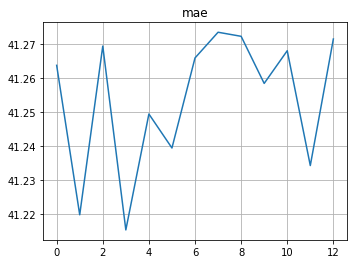

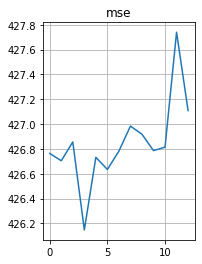

epoch: 1


 results:
Mean square error: 426.67749
Mean absolute error: 41.25868
 results:
Mean square error: 426.72998
Mean absolute error: 41.25745
 results:
Mean square error: 427.01491
Mean absolute error: 41.27350
 results:
Mean square error: 426.90637
Mean absolute error: 41.25873
 results:
Mean square error: 428.33472
Mean absolute error: 41.29203
 results:
Mean square error: 426.66589
Mean absolute error: 41.25848
 results:
Mean square error: 428.05617
Mean absolute error: 41.30011
 results:
Mean square error: 426.95086
Mean absolute error: 41.27209
 results:
Mean square error: 427.18190
Mean absolute error: 41.28375
 results:
Mean square error: 427.42006
Mean absolute error: 41.28623
 results:
Mean square error: 426.87994
Mean absolute error: 41.26724
 results:
Mean square error: 427.09783
Mean absolute error: 41.27073
 results:
Mean square error: 426.93521
Mean absolute error: 41.27224



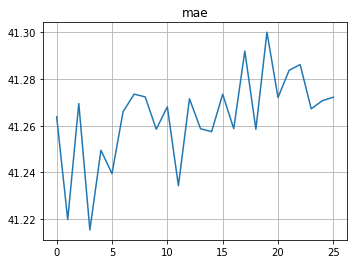

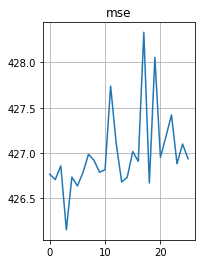

In [30]:
model_first = SalaryPredictor_first().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_first.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': []}
 
for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_first.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_first(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if i % 1000 == 0:
          m = print_metrics(model_first, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()

2. Параллельные сверточные слои. Идея в том, чтобы применить несколько nn.Conv1d к одному и тому же эмбеддингу и после этого сконкатенировать выходные каналы

In [31]:
class SalaryPredictor_second(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_title = nn.Embedding(n_tokens, 32)
        self.conv_title1 = nn.Conv1d(32, 16, 2, padding=2)
        self.conv_title2 = nn.Conv1d(32, 8, 4, padding=3)
        self.conv_title3 = nn.Conv1d(32, 4, 8, padding=7)
        self.pool_title1 = nn.MaxPool1d(2)
        self.pool_title2 = nn.MaxPool1d(4)
        self.pool_title3 = nn.MaxPool1d(8)
        self.flat = nn.Flatten()

        self.emb_des = nn.Embedding(n_tokens, 32)
        self.conv_des1 = nn.Conv1d(32, 16, 2)
        self.conv_des2 = nn.Conv1d(32, 8, 4, padding=3)
        self.conv_des3 = nn.Conv1d(32, 4, 8, padding=7)
        self.pool_des1 = nn.MaxPool1d(2)
        self.pool_des2 = nn.MaxPool1d(4)
        self.pool_des3 = nn.MaxPool1d(8)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
        
    def forward(self, batch):

        title = batch['Title']
        title = self.emb_title(title)
        title = title.permute((0, 2, 1))
        title_1 = self.conv_title1(title)
        title_2 = self.conv_title2(title)
        title_3 = self.conv_title3(title)
        title_1 = self.pool_title1(title_1).mean(1)
        title_2 = self.pool_title2(title_2).mean(1)
        title_3 = self.pool_title3(title_3).mean(1)
        title_1 = self.flat(title_1)
        title_2 = self.flat(title_2)
        title_3 = self.flat(title_3)
        title = torch.cat((title_1, title_2, title_3), dim=1)
 
        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des_1 = self.conv_des1(des)
        des_2 = self.conv_des2(des)
        des_3 = self.conv_des3(des)
        des_1 = self.pool_des1(des_1).mean(1)
        des_2 = self.pool_des2(des_2).mean(1)
        des_3 = self.pool_des3(des_3).mean(1)
        des_1 = self.flat(des_1)
        des_2 = self.flat(des_2)
        des_3 = self.flat(des_3)
        des = torch.cat((des_1, des_2, des_3), dim=1)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, des, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()
        
Salary_Pred_second = SalaryPredictor_second()   

In [32]:
model_second = SalaryPredictor_second()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_second(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [33]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


 results:
Mean square error: 426.90515
Mean absolute error: 41.26240
 results:
Mean square error: 428.95997
Mean absolute error: 41.29730
 results:
Mean square error: 427.40204
Mean absolute error: 41.27247
 results:
Mean square error: 427.30004
Mean absolute error: 41.24906
 results:
Mean square error: 434.83730
Mean absolute error: 41.42543
 results:
Mean square error: 427.48190
Mean absolute error: 41.24136
 results:
Mean square error: 426.85241
Mean absolute error: 41.26022
 results:
Mean square error: 427.66287
Mean absolute error: 41.25861
 results:
Mean square error: 430.54056
Mean absolute error: 41.34964
 results:
Mean square error: 430.13100
Mean absolute error: 41.29167
 results:
Mean square error: 427.12512
Mean absolute error: 41.26120
 results:
Mean square error: 426.87810
Mean absolute error: 41.25436
 results:
Mean square error: 431.97692
Mean absolute error: 41.27848



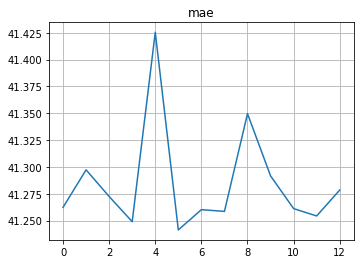

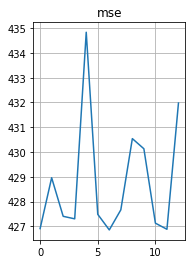

epoch: 1


 results:
Mean square error: 432.48256
Mean absolute error: 41.30394
 results:
Mean square error: 426.59105
Mean absolute error: 41.21247
 results:
Mean square error: 428.10482
Mean absolute error: 41.27021
 results:
Mean square error: 426.55290
Mean absolute error: 41.22928
 results:
Mean square error: 426.71846
Mean absolute error: 41.24668
 results:
Mean square error: 426.51283
Mean absolute error: 41.21165
 results:
Mean square error: 428.07369
Mean absolute error: 41.30092
 results:
Mean square error: 426.89988
Mean absolute error: 41.24294
 results:
Mean square error: 429.00891
Mean absolute error: 41.30551
 results:
Mean square error: 429.37422
Mean absolute error: 41.29498
 results:
Mean square error: 427.74363
Mean absolute error: 41.22410
 results:
Mean square error: 427.25703
Mean absolute error: 41.27852
 results:
Mean square error: 426.64649
Mean absolute error: 41.24595



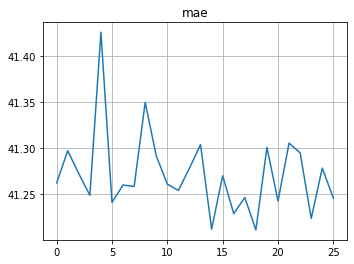

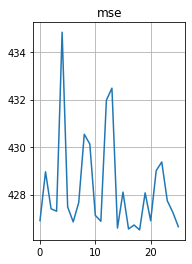

In [34]:
model_second = SalaryPredictor_second().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_second.parameters(), lr=1e-4)
metrics = {'mse': [], 'mae': []}
 
for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_second.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_second(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
 
        if i % 1000 == 0:
          m = print_metrics(model_second, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()

Больше слоев...

In [35]:
class SalaryPredictor_third(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_title = nn.Embedding(n_tokens, 32)
        self.conv_title1 = nn.Conv1d(32, 32, 2)
        self.relu_title = nn.ReLU()
        self.flat = nn.Flatten()
        self.conv_title2 = nn.Conv1d(32, 16, 2)
        self.conv_title3 = nn.Conv1d(16, 16, 1)
        self.pool_title1 = nn.MaxPool1d(2)
        self.pool_title2 = nn.MaxPool1d(1)

        self.emb_des = nn.Embedding(n_tokens, 32)
        self.conv_des1 = nn.Conv1d(32, 32, 2)
        self.relu_des = nn.ReLU()
        self.conv_des2 = nn.Conv1d(32, 16, 2)
        self.conv_des3 = nn.Conv1d(16, 16, 1)
        self.pool_des1 = nn.MaxPool1d(2)
        self.pool_des2 = nn.MaxPool1d(1)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
        
    def forward(self, batch):

        title = batch['Title']
        title = self.emb_title(title)
        title = title.permute((0, 2, 1))
        title = self.conv_title1(title)
        title = self.relu_title(title)
        title = self.conv_title2(title)
        title = self.relu_title(title)
        title = self.pool_title1(title)
        title = self.relu_title(title)
        title = self.conv_title3(title)
        title = self.relu_title(title)
        title = self.pool_title2(title)
        title = self.flat(title)
 
        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des1(des)
        des = self.relu_des(des)
        des = self.conv_des2(des)
        des = self.relu_des(des)
        des = self.pool_des1(des)
        des = self.relu_des(des)
        des = self.conv_des3(des)
        des = self.relu_des(des)
        des = self.pool_des2(des)
        des = self.flat(des)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, des, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()
        
        
Salary_Pred_third = SalaryPredictor_third()   

In [36]:
model_third = SalaryPredictor_third()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_third(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [37]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


 results:
Mean square error: 426.80715
Mean absolute error: 41.22604
 results:
Mean square error: 428.26757
Mean absolute error: 41.29952
 results:
Mean square error: 427.80392
Mean absolute error: 41.27673
 results:
Mean square error: 427.38856
Mean absolute error: 41.25513
 results:
Mean square error: 428.27345
Mean absolute error: 41.30030
 results:
Mean square error: 427.96842
Mean absolute error: 41.28384
 results:
Mean square error: 427.62018
Mean absolute error: 41.26741
 results:
Mean square error: 427.40069
Mean absolute error: 41.25963
 results:
Mean square error: 427.33333
Mean absolute error: 41.25328
 results:
Mean square error: 427.89163
Mean absolute error: 41.28127
 results:
Mean square error: 428.16920
Mean absolute error: 41.29530
 results:
Mean square error: 428.03795
Mean absolute error: 41.28950
 results:
Mean square error: 427.79297
Mean absolute error: 41.27512



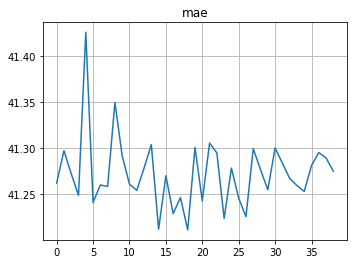

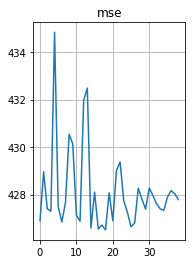

epoch: 1


 results:
Mean square error: 426.82128
Mean absolute error: 41.23162
 results:
Mean square error: 426.77667
Mean absolute error: 41.22713
 results:
Mean square error: 428.16801
Mean absolute error: 41.29278
 results:
Mean square error: 428.39542
Mean absolute error: 41.30524
 results:
Mean square error: 428.22271
Mean absolute error: 41.29625
 results:
Mean square error: 425.81103
Mean absolute error: 41.18076
 results:
Mean square error: 428.26724
Mean absolute error: 41.30093
 results:
Mean square error: 426.53088
Mean absolute error: 41.21505
 results:
Mean square error: 426.96046
Mean absolute error: 41.23707
 results:
Mean square error: 427.66181
Mean absolute error: 41.26955
 results:
Mean square error: 427.90147
Mean absolute error: 41.28065
 results:
Mean square error: 427.89036
Mean absolute error: 41.28238
 results:
Mean square error: 427.10711
Mean absolute error: 41.24455



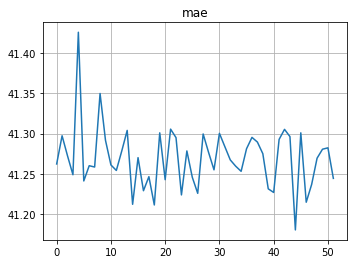

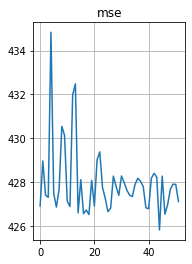

In [38]:
model_third = SalaryPredictor_third().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_third.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_third.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_third(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 1000 == 0:
          m = print_metrics(model_second, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()


Добавим раннюю остановку

In [39]:
class EarlyStopping:
  def __init__(self, patience, eps):
    self.patience = patience
    self.eps = eps
    self.prev_loss = 10000
    self.stagnant_epochs_number = 0
    self.delta = 0
    
  def toStop(self, loss):
    if self.prev_loss == 10000:
      self.delta = loss
    else:
      self.delta = self.prev_loss - loss

    if self.delta < self.eps:
      self.stagnant_epochs_number += 1
      return self.stagnant_epochs_number >= self.patience

stopping = EarlyStopping(patience=2, eps=1e-3)

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


 results:
Mean square error: 428.03039
Mean absolute error: 41.28873
 results:
Mean square error: 428.16887
Mean absolute error: 41.29471
 results:
Mean square error: 427.72986
Mean absolute error: 41.27227
 results:
Mean square error: 427.97275
Mean absolute error: 41.28638
 results:
Mean square error: 427.39575
Mean absolute error: 41.25640
 results:
Mean square error: 427.85494
Mean absolute error: 41.28002
 results:
Mean square error: 427.41773
Mean absolute error: 41.25888
 results:
Mean square error: 428.14224
Mean absolute error: 41.29395
 results:
Mean square error: 426.82328
Mean absolute error: 41.22958
 results:
Mean square error: 428.03215
Mean absolute error: 41.28907
 results:
Mean square error: 428.35061
Mean absolute error: 41.30503
 results:
Mean square error: 428.09918
Mean absolute error: 41.28957
 results:
Mean square error: 426.86605
Mean absolute error: 41.23003



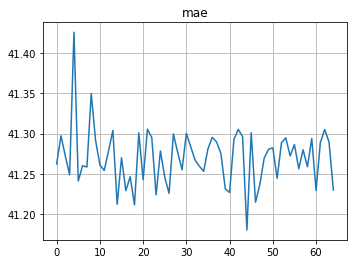

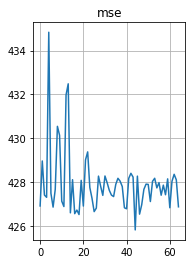

epoch: 1


 results:
Mean square error: 427.77202
Mean absolute error: 41.27442
 results:
Mean square error: 428.35351
Mean absolute error: 41.30261
 results:
Mean square error: 428.10029
Mean absolute error: 41.29021
 results:
Mean square error: 427.28231
Mean absolute error: 41.25087
 results:
Mean square error: 427.99261
Mean absolute error: 41.28463
 results:
Mean square error: 428.43325
Mean absolute error: 41.30627
 results:
Mean square error: 427.31814
Mean absolute error: 41.25255
 results:
Mean square error: 427.69563
Mean absolute error: 41.27249
 results:
Mean square error: 426.75482
Mean absolute error: 41.22611
 results:
Mean square error: 428.10952
Mean absolute error: 41.29143
 results:
Mean square error: 426.88713
Mean absolute error: 41.23296
 results:
Mean square error: 427.29534
Mean absolute error: 41.25350
 results:
Mean square error: 427.83566
Mean absolute error: 41.27594



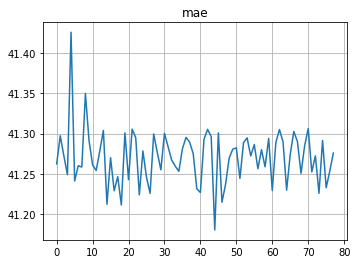

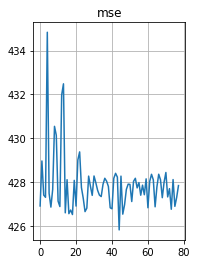

In [40]:
for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_second.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_second(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        if stopping.toStop(loss):
          break
        optimizer.step()
 
        if i % 1000 == 0:
          m = print_metrics(model_second, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()

Добавление параллельных сверточных слоев и увеличение их количества не сильно полвияло на качество модели, ранняя остановка результат показала хороший + предотвращает переобучение.

# 2. Pooling слои стандартные (1 балла)

1. Опишите своими словами как работает Pooling слой.
2. Взять максимум по временной компоненте (незавимисо для каждой фичи)
3. Взять среднее по временной компоненте (исключая PAD символы)
Применять можно к любой архитектуре (CNN/RNN)

1. Pooling слой уменьшает размер изначального тензора с помощью вычисления функции на каждом блоке, на которые делится изначальный тензор (это может быть функция max pooling или mean pooling).

2. Сделали в первой CNN архитектуре (задание 1.1).

3. Возьмем теперь среднее по временной компоненте в первой CNN архитектуре:

In [41]:
class SalaryPredictor_sixth(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.emb_title = nn.Embedding(n_tokens, 32)
        self.batch_title = nn.BatchNorm1d(32)
        self.conv_title = nn.Conv1d(32, 16, 2)
        self.pool_title = nn.AvgPool1d(2, count_include_pad=False)

        self.emb_des = nn.Embedding(n_tokens, 32)
        self.batch_des = nn.BatchNorm1d(32)
        self.conv_des = nn.Conv1d(32, 16, 2)
        self.pool_des = nn.AvgPool1d(2, count_include_pad=False)

        self.full_cat = nn.Linear(n_cat_features, hid_size)
        
    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        title = title.permute((0, 2, 1))
        title = self.conv_title(title)
        title = self.pool_title(title).mean(1)

        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des(des)
        des = self.pool_des(des).mean(1)

        cat = self.full_cat(batch['Categorical'])

        concat = torch.cat((title, des, cat), dim=1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()
        
        
Salary_Pred_sixth = SalaryPredictor_sixth()   

In [42]:
model_sixth = SalaryPredictor_sixth()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_sixth(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [43]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


 results:
Mean square error: 426.59477
Mean absolute error: 41.21729
 results:
Mean square error: 426.86838
Mean absolute error: 41.23175
 results:
Mean square error: 428.25592
Mean absolute error: 41.29926
 results:
Mean square error: 427.08775
Mean absolute error: 41.24135
 results:
Mean square error: 428.57782
Mean absolute error: 41.31217
 results:
Mean square error: 426.42120
Mean absolute error: 41.21020
 results:
Mean square error: 427.46863
Mean absolute error: 41.26061
 results:
Mean square error: 427.45919
Mean absolute error: 41.26051
 results:
Mean square error: 426.27275
Mean absolute error: 41.20229
 results:
Mean square error: 427.86822
Mean absolute error: 41.28004
 results:
Mean square error: 428.03109
Mean absolute error: 41.28827
 results:
Mean square error: 427.26450
Mean absolute error: 41.25138
 results:
Mean square error: 427.86516
Mean absolute error: 41.28030



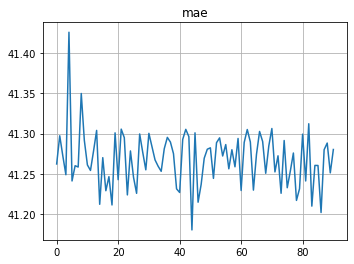

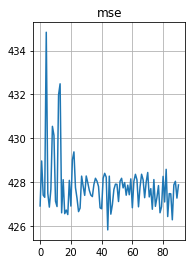

epoch: 1


 results:
Mean square error: 427.74011
Mean absolute error: 41.27357
 results:
Mean square error: 428.05907
Mean absolute error: 41.28991
 results:
Mean square error: 428.37557
Mean absolute error: 41.30347
 results:
Mean square error: 428.28864
Mean absolute error: 41.30041
 results:
Mean square error: 428.07092
Mean absolute error: 41.28999
 results:
Mean square error: 428.58513
Mean absolute error: 41.31507
 results:
Mean square error: 427.39649
Mean absolute error: 41.25668
 results:
Mean square error: 427.05012
Mean absolute error: 41.24056
 results:
Mean square error: 428.13117
Mean absolute error: 41.29127
 results:
Mean square error: 427.41687
Mean absolute error: 41.25653
 results:
Mean square error: 427.99310
Mean absolute error: 41.28673
 results:
Mean square error: 427.82864
Mean absolute error: 41.27920
 results:
Mean square error: 428.04600
Mean absolute error: 41.28816



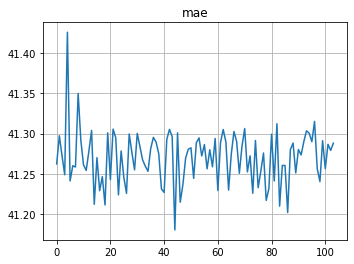

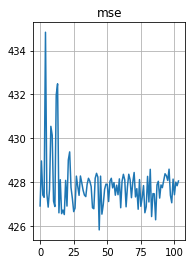

In [44]:
model_sixth = SalaryPredictor_sixth().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_sixth.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_sixth.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_sixth(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#    print_metrics(model_sixth, data_val)
        if i % 1000 == 0:
          m = print_metrics(model_second, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()

# 3. Используйте предобученные эмбеддинги (2 балла)

1. Загрузите предобученные эмбеддинги с помощью gensim.downloader.load. 
2. Используйте метод from_pretrained слоя torch.nn.Embedding для инициализации эмбеддингов с помощью предобученных весов. Можете попбровать несколько типов предобученных эмбеддингов.
3. Проведите эксперементы с обучаемыми/замороженными весами эмбеддингов. 
- Используйте одни и те же эмбеддинги для Title и FullDescription.
Сравните результаты:

1. Эмбеддингов, инициализируемых случайно из
N(0,1) 
(по умолчанию у слоя torch.nn.Embedding)
2. Предобученных эмбеддингов с замороженными весами
3. Предобученных эмбеддингов с обучаемыми весами
- Что изменяется в поведении модели? Какой эксперимент дал лучший результат?

`1. Случайно из N(0, 1) сделали в первом задании.

2. Посмотрим на результат предобученных эмбеддингов с замороженными весами:

In [45]:
from gensim.downloader import load as gs_load

In [46]:
class SalaryPredictor_seventh(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        model = gs_load("glove-twitter-25")
        weights = torch.FloatTensor(model.vectors)
        embedding = nn.Embedding.from_pretrained(weights, freeze=True)
        self.emb_title = embedding
        self.conv_title = nn.Conv1d(25, 5, 2)
        self.pool_title = nn.MaxPool1d(2)

        self.emb_des = embedding
        self.conv_des = nn.Conv1d(25, 16, 2)
        self.pool_des = nn.MaxPool1d(2)

        self.full_cat = nn.Linear(n_cat_features, hid_size)


    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        title = title.permute((0, 2, 1))
        title = self.conv_title(title)
        title = self.pool_title(title).mean(1)

        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des(des)
        des = self.pool_des(des).mean(1)

        cat = batch['Categorical']
        cat = (self.full_cat(cat))
        
        concat = torch.cat((title, des, cat), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()

Salary_Pred_seventh = SalaryPredictor_seventh() 

[==================================================] 100.0% 104.8/104.8MB downloaded


In [47]:
model_seventh = SalaryPredictor_seventh()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_seventh(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [48]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


 results:
Mean square error: 427.75364
Mean absolute error: 41.27510
 results:
Mean square error: 427.87475
Mean absolute error: 41.28017
 results:
Mean square error: 429.15339
Mean absolute error: 41.34208
 results:
Mean square error: 427.02492
Mean absolute error: 41.23999
 results:
Mean square error: 428.82949
Mean absolute error: 41.32706
 results:
Mean square error: 427.81953
Mean absolute error: 41.27513
 results:
Mean square error: 427.94620
Mean absolute error: 41.28372
 results:
Mean square error: 427.70600
Mean absolute error: 41.27119
 results:
Mean square error: 428.10613
Mean absolute error: 41.29188
 results:
Mean square error: 427.35470
Mean absolute error: 41.25568
 results:
Mean square error: 428.06520
Mean absolute error: 41.29051
 results:
Mean square error: 427.77533
Mean absolute error: 41.27676
 results:
Mean square error: 427.62733
Mean absolute error: 41.26699



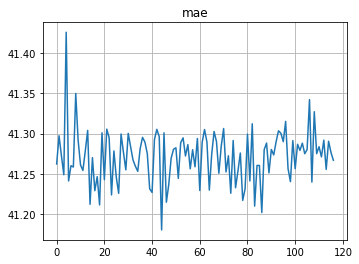

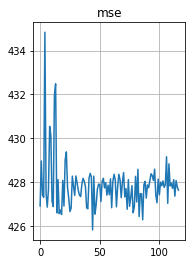

epoch: 1


 results:
Mean square error: 428.96895
Mean absolute error: 41.33213
 results:
Mean square error: 427.28382
Mean absolute error: 41.25034
 results:
Mean square error: 428.50874
Mean absolute error: 41.30848
 results:
Mean square error: 427.11001
Mean absolute error: 41.24330
 results:
Mean square error: 426.72872
Mean absolute error: 41.22480
 results:
Mean square error: 427.41585
Mean absolute error: 41.25688
 results:
Mean square error: 428.44861
Mean absolute error: 41.31030
 results:
Mean square error: 428.24898
Mean absolute error: 41.29657
 results:
Mean square error: 427.84747
Mean absolute error: 41.27766
 results:
Mean square error: 429.12226
Mean absolute error: 41.33949
 results:
Mean square error: 427.79355
Mean absolute error: 41.27685
 results:
Mean square error: 426.40625
Mean absolute error: 41.20994
 results:
Mean square error: 426.54060
Mean absolute error: 41.21479



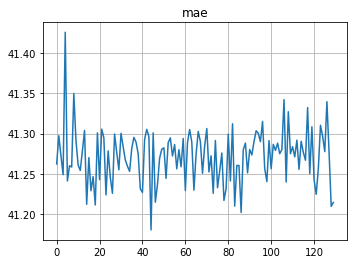

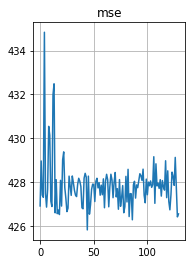

In [50]:
model_seventh = SalaryPredictor_seventh().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_seventh.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_seventh.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_seventh(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#    print_metrics(model_seventh, data_val)
        if i % 1000 == 0:
          m = print_metrics(model_second, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()

3. Теперь попробуем с обучаемыми весами:

In [51]:
class SalaryPredictor_eighth(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        model = gs_load("glove-twitter-25")
        weights = torch.FloatTensor(model.vectors)
        embedding = nn.Embedding.from_pretrained(weights, freeze=False)
        self.emb_title = embedding
        self.conv_title = nn.Conv1d(25, 5, 2)
        self.pool_title = nn.MaxPool1d(2)

        self.emb_des = embedding
        self.conv_des = nn.Conv1d(25, 16, 2)
        self.pool_des = nn.MaxPool1d(2)

        self.full_cat = nn.Linear(n_cat_features, hid_size)


    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        title = title.permute((0, 2, 1))
        title = self.conv_title(title)
        title = self.pool_title(title).mean(1)

        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des(des)
        des = self.pool_des(des).mean(1)

        cat = batch['Categorical']
        cat = (self.full_cat(cat))
        
        concat = torch.cat((title, des, cat), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        return out.squeeze()

Salary_Pred_eighth = SalaryPredictor_eighth()

In [52]:
model_eighth = SalaryPredictor_eighth()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_eighth(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [53]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


 results:
Mean square error: 428.12459
Mean absolute error: 41.29236
 results:
Mean square error: 428.80882
Mean absolute error: 41.32650
 results:
Mean square error: 427.27475
Mean absolute error: 41.25089
 results:
Mean square error: 427.78399
Mean absolute error: 41.27359
 results:
Mean square error: 427.56581
Mean absolute error: 41.26362
 results:
Mean square error: 426.84812
Mean absolute error: 41.23079
 results:
Mean square error: 426.96916
Mean absolute error: 41.23656
 results:
Mean square error: 427.98252
Mean absolute error: 41.28561
 results:
Mean square error: 426.78611
Mean absolute error: 41.22620
 results:
Mean square error: 427.83170
Mean absolute error: 41.27844
 results:
Mean square error: 427.11961
Mean absolute error: 41.24503
 results:
Mean square error: 427.65102
Mean absolute error: 41.26900
 results:
Mean square error: 426.98105
Mean absolute error: 41.23767



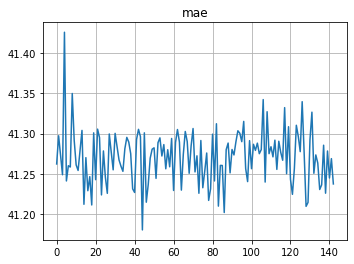

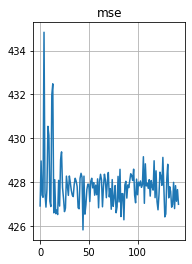

epoch: 1


 results:
Mean square error: 427.96029
Mean absolute error: 41.28397
 results:
Mean square error: 428.22255
Mean absolute error: 41.29813
 results:
Mean square error: 428.44261
Mean absolute error: 41.30780
 results:
Mean square error: 428.29195
Mean absolute error: 41.30056
 results:
Mean square error: 426.53930
Mean absolute error: 41.21543
 results:
Mean square error: 427.61442
Mean absolute error: 41.26757
 results:
Mean square error: 428.51883
Mean absolute error: 41.30976
 results:
Mean square error: 428.02741
Mean absolute error: 41.28896
 results:
Mean square error: 427.60025
Mean absolute error: 41.26797
 results:
Mean square error: 427.67618
Mean absolute error: 41.26956
 results:
Mean square error: 428.30940
Mean absolute error: 41.30086
 results:
Mean square error: 427.61266
Mean absolute error: 41.26796
 results:
Mean square error: 428.03015
Mean absolute error: 41.28839



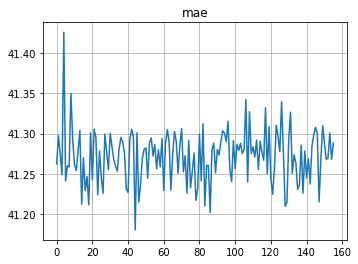

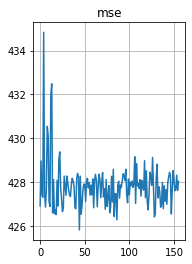

In [54]:
model_eighth = SalaryPredictor_seventh().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_eighth.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_eighth.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_eighth(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#    print_metrics(model_eighth, data_val)
        if i % 1000 == 0:
          m = print_metrics(model_second, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()

Вывод: эксперимент с обучаемыми весами дал лучший результат.

# 4. Замените сверточные слои на рекуррентные (3 балла)

Замените сверточные слоим рекуррентными LSTM/GRU.
Проведите эксперимент с однонаправленной и двунаправленной рекуррентной нейросетью
Попробуйте найти удачный микс рекуррентных и сверточных слоев. Попробуйте разные миксы для Title и FullDescription

In [98]:
class SalaryPredictor_ninth(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), num_of_h_layers = 2, hid_size=8):
        super().__init__()
        self.flat = nn.Flatten()
        self.emb_title = nn.Embedding(n_tokens, 32)
        
        self.batch_title = nn.BatchNorm1d(32)
        self.conv_title = nn.Conv1d(32, 16, 2, padding=2)
        self.relu_title = nn.ReLU()
        self.pool_title = nn.MaxPool1d(2)

        self.emb_des = nn.Embedding(n_tokens, 32)
        self.batch_des = nn.BatchNorm1d(32)

        self.number_of_hidden_layers = num_of_h_layers
        self.hidden_size = hid_size
        self.rnn = nn.GRU(32, hid_size, num_of_h_layers, batch_first=True)
        self.fc = nn.Linear(hid_size, 1)
        

        self.full_cat = nn.Linear(n_cat_features, hid_size)

        self.soft = nn.Softmax(dim=1)


    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        title = title.permute((0, 2, 1))
        title = self.conv_title(title)
        title = self.relu_title(title)
        title = self.pool_title(title).mean(1)
        title = self.flat(title)

        
        description = batch['FullDescription']
        description = self.emb_des(description)
        

        h0 = torch.zeros(self.number_of_hidden_layers, description.size(0), self.hidden_size)
        description, _ = self.rnn(description, h0)
        description = description[:, -1, :]
        description = self.fc(description)

        categorical = batch['Categorical']
        categorical = (self.full_cat(categorical))
        
        concat = torch.cat((title, description, categorical), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        out = self.soft(out)
        
        return out.squeeze()

Salary_Pred_ninth = SalaryPredictor_ninth() 

In [99]:
model_ninth = SalaryPredictor_ninth()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_ninth(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [100]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

In [102]:
model_ninth = SalaryPredictor_ninth().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_ninth.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_ninth.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_ninth(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
print_metrics(model_ninth, data_val)

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



epoch: 1



 results:
Mean square error: 348.20903
Mean absolute error: 37.26687


(348.2090277777778, 37.266870915032676)

Попробуем реккурентную сеть на Title

In [55]:
class SalaryPredictor_tenth(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), num_of_h_layers = 2, hid_size=8):
        super().__init__()
        self.flat = nn.Flatten()
        self.emb_title = nn.Embedding(n_tokens, 32)   
        self.batch_title = nn.BatchNorm1d(32)

        self.emb_des = nn.Embedding(n_tokens, 32)
        self.batch_des = nn.BatchNorm1d(32)
        self.conv_des = nn.Conv1d(32, 16, 2, padding=2)
        self.relu_des = nn.ReLU()
        self.pool_des = nn.MaxPool1d(2)

        self.number_of_hidden_layers = num_of_h_layers
        self.hidden_size = hid_size
        self.rnn = nn.GRU(32, hid_size, num_of_h_layers, batch_first=True)
        self.fc = nn.Linear(hid_size, 1)
        
        self.full_cat = nn.Linear(n_cat_features, hid_size)

        self.soft = nn.Softmax(dim=1)

    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        
        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des(des)
        des = self.relu_des(des)
        des = self.pool_des(des).mean(1)
        des = self.flat(des)
        

        h0 = torch.zeros(self.number_of_hidden_layers, title.size(0), self.hidden_size)
        title, _ = self.rnn(title, h0)
        title = title[:, -1, :]
        title = self.fc(title)

        categorical = batch['Categorical']
        categorical = (self.full_cat(categorical))
        
        concat = torch.cat((title, des, categorical), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        out = self.soft(out)
        
        return out.squeeze()

Salary_Pred_tenth = SalaryPredictor_tenth() 

In [56]:
model_tenth = SalaryPredictor_tenth()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_tenth(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [57]:
#запусили для 2 эпох, было 5
import tqdm

BATCH_SIZE = 16
EPOCHS = 2
DEVICE = torch.device('cpu')

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


 results:
Mean square error: 426.50478
Mean absolute error: 41.21415
 results:
Mean square error: 427.69408
Mean absolute error: 41.27086
 results:
Mean square error: 426.17537
Mean absolute error: 41.19698
 results:
Mean square error: 427.48162
Mean absolute error: 41.26147
 results:
Mean square error: 426.52966
Mean absolute error: 41.21587
 results:
Mean square error: 426.74522
Mean absolute error: 41.22552
 results:
Mean square error: 426.36430
Mean absolute error: 41.20553
 results:
Mean square error: 428.43734
Mean absolute error: 41.30867
 results:
Mean square error: 428.15229
Mean absolute error: 41.29530
 results:
Mean square error: 428.18056
Mean absolute error: 41.29415
 results:
Mean square error: 428.32014
Mean absolute error: 41.30010
 results:
Mean square error: 428.02243
Mean absolute error: 41.28791
 results:
Mean square error: 427.83930
Mean absolute error: 41.27870



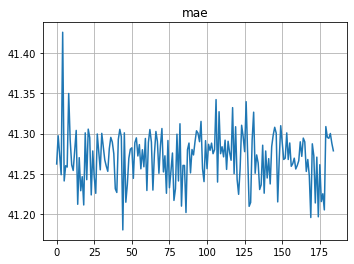

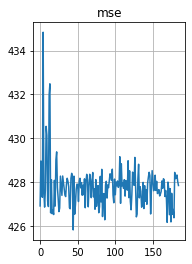

epoch: 1


 results:
Mean square error: 426.97696
Mean absolute error: 41.23563
 results:
Mean square error: 426.81352
Mean absolute error: 41.22779
 results:
Mean square error: 427.54016
Mean absolute error: 41.26442
 results:
Mean square error: 428.36936
Mean absolute error: 41.30334
 results:
Mean square error: 427.22696
Mean absolute error: 41.24975
 results:
Mean square error: 427.78840
Mean absolute error: 41.27538
 results:
Mean square error: 427.45502
Mean absolute error: 41.26001
 results:
Mean square error: 427.90846
Mean absolute error: 41.28159
 results:
Mean square error: 426.84600
Mean absolute error: 41.23057
 results:
Mean square error: 427.80327
Mean absolute error: 41.27621
 results:
Mean square error: 426.26511
Mean absolute error: 41.20168
 results:
Mean square error: 426.94375
Mean absolute error: 41.23604
 results:
Mean square error: 427.95147
Mean absolute error: 41.28302



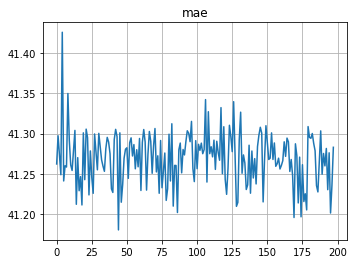

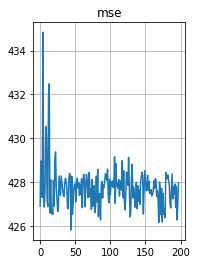

In [59]:
model_tenth = SalaryPredictor_tenth().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_tenth.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_tenth.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_tenth(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
#    print_metrics(model_tenth, data_val)
        if i % 1000 == 0:
          m = print_metrics(model_second, data_val)
          metrics['mse'].append(m[0])
          metrics['mae'].append(m[1])
 
    plt.figure(figsize=(12,4))
    for j, (name, history) in enumerate(sorted(metrics.items())):
      plt.subplot(1, len(metrics), j + 1)
      plt.title(name)
      plt.plot(history)
      plt.grid()
      plt.show()

Добавим двунаправленность

In [28]:
class SalaryPredictor_two_orient(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), num_of_h_layers = 2, hid_size=8):
        super().__init__()
        self.flat = nn.Flatten()
        self.emb_title = nn.Embedding(n_tokens, 32)   
        self.batch_title = nn.BatchNorm1d(32)
 
        self.emb_des = nn.Embedding(n_tokens, 32)
        self.batch_des = nn.BatchNorm1d(32)
        self.conv_des = nn.Conv1d(32, 16, 2, padding=2)
        self.relu_des = nn.ReLU()
        self.pool_des = nn.MaxPool1d(2)
 
        self.number_hidd_l = num_of_h_layers
        self.hid_size = hid_size
        self.rnn = nn.GRU(32 , hid_size, num_of_h_layers, batch_first = True, bidirectional=True)
        self.fc = nn.Linear(16, 16)
        
        self.full_cat = nn.Linear(n_cat_features, hid_size)
 
        self.soft = nn.Softmax(dim=1)
 
    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        
        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des(des)
        des = self.relu_des(des)
        des = self.pool_des(des).mean(1)
        des = self.flat(des)
        
 
        h0 = torch.zeros(self.number_hidd_l+2, title.size(0), self.hid_size)
        title, _ = self.rnn(title, h0)
        title = title[:, -1, :]
        title = self.fc(title)
 
        categorical = batch['Categorical']
        categorical = (self.full_cat(categorical))
        
        concat = torch.cat((title, des, categorical), dim = 1)
 
        out = nn.Linear(concat.shape[1], 1)(concat)
        out = self.soft(out)
        
        return out.squeeze()

Salary_Pred_two_orient = SalaryPredictor_two_orient()

In [61]:
model_two_orient = SalaryPredictor_two_orient()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model_two_orient(batch)
dummy_loss = criterion(dummy_pred, batch['target_column'])

In [62]:
model_two_orient = SalaryPredictor_two_orient().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_two_orient.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_two_orient.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_two_orient(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print_metrics(model_two_orient, data_val)

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



 results:
Mean square error: 348.20903
Mean absolute error: 37.26687
epoch: 1



 results:
Mean square error: 348.20903
Mean absolute error: 37.26687


Замена сверточных слоев реккурентным дала хороший результат, ошибка значительно уменьшилась по сравнению с предыдущими моделями. Двунаправленность результат улучшила незначительно по сравнению с однонаправленностью.

# 5. Вытащите признаки из нейронной сети и используйте их в ансамбле деревьев решений. (2 балла)

Вытащите признаки с предпоследнего слоя обученной нейросети и передайте их в ансамбль деревьев решений.
Сравните результаты работы лучшей нейросети и ансамбля деревьев решений, построенном на признаках из этой нейросети. Сможет ли замена последнего слоя на ансамбль деревьев решений улучшить результат?

Модель слишком долго прогружалась.

In [29]:
class SalaryPredictor_eleventh(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), num_of_h_layers = 2, hid_size=8):
        super().__init__()
        self.flat = nn.Flatten()
        self.emb_title = nn.Embedding(n_tokens, 32)   
        self.batch_title = nn.BatchNorm1d(32)

        self.emb_des = nn.Embedding(n_tokens, 32)
        self.batch_des = nn.BatchNorm1d(32)
        self.conv_des = nn.Conv1d(32, 16, 2, padding=2)
        self.relu_des = nn.ReLU()
        self.pool_des = nn.MaxPool1d(2)

        self.number_of_hidden_layers = num_of_h_layers
        self.hidden_size = hid_size
        self.rnn = nn.GRU(32, hid_size, num_of_h_layers, batch_first=True)
        self.fc = nn.Linear(hid_size, 1)
        
        self.full_cat = nn.Linear(n_cat_features, hid_size)

        self.soft = nn.Softmax(dim=1)

    def forward(self, batch):
        title = batch['Title']
        title = self.emb_title(title)
        
        des = batch['FullDescription']
        des = self.emb_des(des)
        des = des.permute((0, 2, 1))
        des = self.conv_des(des)
        des = self.relu_des(des)
        des = self.pool_des(des).mean(1)
        des = self.flat(des)
        

        h0 = torch.zeros(self.number_of_hidden_layers, title.size(0), self.hidden_size)
        title, _ = self.rnn(title, h0)
        title = title[:, -1, :]
        title = self.fc(title)

        categorical = batch['Categorical']
        categorical = (self.full_cat(categorical))
        
        concat = torch.cat((title, des, categorical), dim = 1)

        out = nn.Linear(concat.shape[1], 1)(concat)
        out = self.soft(out)
        
        return out.squeeze()

Salary_Pred_eleventh = SalaryPredictor_eleventh() 

In [30]:
model_eleventh = SalaryPredictor_eleventh().to(DEVICE)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model_eleventh.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model_eleventh.train()
    for i, batch in tqdm.tqdm_notebook(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=DEVICE)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model_eleventh(batch)
        loss = criterion(pred, batch['target_column'])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
print_metrics(model_eleventh, data_val)

epoch: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



epoch: 1



 results:
Mean square error: 348.20903
Mean absolute error: 37.26687


(348.2090277777778, 37.266870915032676)

In [36]:
rf_param = model_eleventh.layer[0].weight

In [ ]:
from sklearn.model_selection import train_test_split

(trainData, testData, train_label, test_label) = train_test_split(data.drop(columns = 'Log1pSalary'), data['Log1pSalary'], test_size=0.2)

In [ ]:
rf_model = RandomForestClassifier()

In [ ]:
param_grid = {'n_estimators': [i for i in range(1, 41, 5)],
'max_depth': [6, 10],
'min_samples_leaf': [1, 2, 4]}

In [ ]:
start = time.time()
cv_rs = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=100, cv=5, random_state=42,
scoring='f1', n_jobs=-1)
cv_rs.fit(trainData, train_label)
end=time.time()
print(end-start)

In [ ]:
print(cv_rs.best_params_)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

clf = RandomForestClassifier(n_estimators=max_depth=cv_rs.best_params_.get('n_estimators'), max_depth=cv_rs.best_params_.get('max_depth'), min_samples_leaf=max_depth=cv_rs.best_params_.get('min_samples_leaf'),random_state=0, class_weight = rf_param)
clf.fit(trainData, train_label)


In [ ]:
preds = rf_model.predict(testData)

In [ ]:
print('F1-Score:', metrics.f1_score(test_label, preds), 'Accuracy: ', metrics.accuracy_score(test_label, preds)) #score ensemble